# 第9章　自動着色

共通モジュールの読み込み

In [1]:
import os
import glob
import math
import random

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**リスト9.1:データの読み込み**

In [2]:
data_path = 'img/colorize'
data_lists = glob.glob(os.path.join(data_path, '*.jpg'))

val_n_sample = math.floor(len(data_lists)*0.1)
test_n_sample = math.floor(len(data_lists)*0.1)
train_n_sample = len(data_lists) - val_n_sample - test_n_sample

val_lists = data_lists[:val_n_sample]
test_lists = data_lists[val_n_sample:val_n_sample + test_n_sample]
train_lists = data_lists[val_n_sample + test_n_sample:train_n_sample + val_n_sample + test_n_sample]

In [3]:
print(len(train_lists), len(val_lists), len(test_lists))

23464 2932 2932


**リスト9.2 前処理：「RGB」を「LAB」に変換**

In [4]:
import cv2


img_size = 224
def rgb2lab(rgb):
    assert rgb.dtype == 'uint8'
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)

def lab2rgb(lab):
    assert lab.dtype == 'uint8'
    return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

def get_lab_from_data_list(data_list):
    x_lab = []
    for f in data_list:
        rgb = img_to_array(
            load_img(
                f, 
                target_size=(img_size, img_size)
            )
        ).astype(np.uint8)
        lab = rgb2lab(rgb)
        x_lab.append(lab)
    return np.stack(x_lab)

**リスト9.3:モデルの構築**

In [5]:
from tensorflow.python.keras.layers import Conv2DTranspose


autoencoder = Sequential()
# Encoder
autoencoder.add(
    Conv2D(
        32, 
        (3, 3), 
        (1, 1), 
        activation='relu', 
        padding='same', 
        input_shape=(224, 224, 1)
    )
)
autoencoder.add(
    Conv2D(
        64, # チャネル数を増やしていく
        (3, 3),
        (2, 2), # サイズは半分 (stride=2)
        activation='relu',
        padding='same'
    )
)
autoencoder.add(
    Conv2D(
        128, # チャネル数を増やしていく
        (3, 3), 
        (2, 2), # サイズは半分 (stride=2)
        activation='relu', 
        padding='same'
    )
)
autoencoder.add(
    Conv2D(
        256, # チャネル数を増やしていく
        (3, 3), 
        (2, 2), # サイズは半分 (stride=2)
        activation='relu', 
        padding='same')
)
# Decoder
autoencoder.add(
    Conv2DTranspose(
        128,  # チャネル数を半分に
        (3, 3), 
        (2, 2),  # サイズは2倍
        activation='relu', 
        padding='same'
    )
)
autoencoder.add(
    Conv2DTranspose(
        64, # チャネル数を半分に
        (3, 3), 
        (2, 2),  # サイズは2倍
        activation='relu',
        padding='same'
    )
)
autoencoder.add(
    Conv2DTranspose(
        32, # チャネル数を半分に
        (3, 3), 
        (2, 2),  # サイズは2倍
        activation='relu', 
        padding='same'
    )
)
autoencoder.add(
    Conv2D(
        2, 
        (1, 1),  # 1x1
        (1, 1), 
        activation='relu',  # chapter8ではsigmoidを使っていたがreluを使う
        padding='same'
    )
)
autoencoder.compile(optimizer='adam', loss='mse') # chapter8ではbinary_crossentropyだったがMSE
autoencoder.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 112, 112, 64)      73792     
_________________________________________________________________
con

In [ ]:
# Conv2DTranspose(stride=2) と Upsampling2D(size=2) + Conv2D(stride=1)の違い
#     https://stackoverflow.com/questions/48226783/what-is-the-the-difference-between-performing-upsampling-together-with-strided-t

**リスト9.4:サマリの確認**

In [6]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 112, 112, 64)      73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 224, 224, 32)      18464     
__________

**リスト9.5 ジェネレータ関数の定義**

In [7]:
def generator_with_preprocessing(data_list, batch_size, shuffle=False):
    while True:
        if shuffle:
            np.random.shuffle(data_list) # in-placeで元の並びが変わる
        for i in range(0, len(data_list), batch_size):
            batch_list = data_list[i:i + batch_size] # バッチサイズ取り出し
            batch_lab = get_lab_from_data_list(batch_list) # LABに変換した画像のリスト
            batch_l = batch_lab[:, :, :, 0:1] # 最初のチャネルがL （入力データ）
            batch_ab = batch_lab[:, :, :, 1:] # 残りのチャネルがAB　（教師データ）
            yield (batch_l, batch_ab)

**リスト9.6:学習・検証・評価用ジェネレータの呼び出し**

In [8]:
batch_size = 30

train_gen = generator_with_preprocessing(train_lists, batch_size, shuffle=True) # 学習用のジェネレータはshuffleする
val_gen = generator_with_preprocessing(val_lists, batch_size)
test_gen = generator_with_preprocessing(test_lists, batch_size)

train_steps = math.ceil(len(train_lists)/batch_size)
val_steps = math.ceil(len(val_lists)/batch_size)
test_steps = math.ceil(len(test_lists)/batch_size)

ModelCheckpointというコールバックを用いることで、検証用データに対して最もロス値が低くなるモデルのみ保存を行っています。  
このようにすることで、検証データに対して最も良かった時のパラメータで、予測することができます。

※ただし、簡易化のため、本Jupter Notebookでは実行していません。  
より良い予測モデルで実行したい場合は、以下の手順を行う必要があります。
1. リスト9.7のコールバック箇所のコメントを外し、エポック数を増やす（例えば500、もしくは3000など）
1. 学習後、ディレクトリを確認して、ロス値の低いモデルのパラメータを確認（例えば、'70-258.01.hdf5'のような名前で保存されている）  
1. **追加リスト** のモデルのパラメータを確認した名前に変更後、コメントを外す  
   ロス値が低いモデルのパラメータを読み込み、予測を行う

In [9]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

# 各エポック終了後にモデルを保存します．
valid_ck = ModelCheckpoint('{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks = [valid_ck] 

**リスト9.7 モデルの学習**

※本書で記載されている実行方法と変化している点があります。  
本Jupter Notebookでは、epochは3000から150に変更しており、コールバックは用いていません。  
また、本書での結果は、実際にはコールバックを用いていましたが、今回は簡易化のため、コールバックを使用していません。  
より良い予測モデルで実行したい場合は、上記記載の手順を行う必要があります。

In [10]:
epochs= 150 # 1epochあたり7分かかった。所要見込み1050分=17.5時間
# https://codezine.jp/article/detail/10805
# 「かかった時間が12時間くらいなので……それでも600円です。」

# epochs = 3000

autoencoder.fit_generator(
    generator=train_gen, # ジェネレータは (inputs, targets)のタプル か (inputs, targets, sample_weights)のタプル を返す
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_steps,
    # callbacks=callbacks, # コールバックを使用する場合はコメントアウトを外す
)

Epoch 1/150
783/783 [==============================]783/783 [==============================] - 435s 555ms/step - loss: 1799.5690 - val_loss: 331.7423

Epoch 2/150
783/783 [==============================]783/783 [==============================] - 380s 486ms/step - loss: 360.9213 - val_loss: 278.8909

Epoch 3/150
783/783 [==============================]783/783 [==============================] - 380s 485ms/step - loss: 298.6498 - val_loss: 269.1844

Epoch 4/150
783/783 [==============================]783/783 [==============================] - 380s 486ms/step - loss: 285.2096 - val_loss: 259.3606

Epoch 5/150
783/783 [==============================]783/783 [==============================] - 380s 485ms/step - loss: 276.4116 - val_loss: 297.5103

Epoch 6/150
783/783 [==============================]783/783 [==============================] - 379s 484ms/step - loss: 273.7359 - val_loss: 302.6959

Epoch 7/150
783/783 [==============================]783/783 [==============================] - 379s

783/783 [==============================]783/783 [==============================] - 367s 469ms/step - loss: 280.7256 - val_loss: 282.2315

Epoch 56/150
783/783 [==============================]783/783 [==============================] - 367s 469ms/step - loss: 280.2409 - val_loss: 271.0965

Epoch 57/150
783/783 [==============================]783/783 [==============================] - 367s 469ms/step - loss: 278.3702 - val_loss: 277.1241

Epoch 58/150
783/783 [==============================]783/783 [==============================] - 367s 469ms/step - loss: 278.0942 - val_loss: 276.9559

Epoch 59/150
783/783 [==============================]783/783 [==============================] - 367s 469ms/step - loss: 277.4142 - val_loss: 267.2398

Epoch 60/150
783/783 [==============================]783/783 [==============================] - 367s 469ms/step - loss: 276.9718 - val_loss: 273.3454

Epoch 61/150
783/783 [==============================]783/783 [==============================] - 367s 468ms/

783/783 [==============================]783/783 [==============================] - 367s 469ms/step - loss: 261.0731 - val_loss: 254.7584

Epoch 110/150
783/783 [==============================]783/783 [==============================] - 368s 469ms/step - loss: 260.3367 - val_loss: 262.1723

Epoch 111/150
783/783 [==============================]783/783 [==============================] - 367s 469ms/step - loss: 260.6582 - val_loss: 254.4345

Epoch 112/150
783/783 [==============================]783/783 [==============================] - 367s 469ms/step - loss: 259.4573 - val_loss: 266.1674

Epoch 113/150
783/783 [==============================]783/783 [==============================] - 368s 470ms/step - loss: 260.9682 - val_loss: 250.6583

Epoch 114/150
783/783 [==============================]783/783 [==============================] - 368s 470ms/step - loss: 258.7307 - val_loss: 251.0337

Epoch 115/150
783/783 [==============================]783/783 [==============================] - 367s 

**追加リスト** 最もロス値が低いモデルのパラメータの読み込み

※ただし、簡易化のため、本Jupter Notebookでは実行していません。

In [14]:
# コールバックを使用していた場合、ロス値が最も低いもの（保存されているモデルの中でエポックが大きいもの）を使用する
# autoencoder.load_weights('70-258.01.hdf5')

**リスト9.8:モデルの予測**

In [13]:
preds = autoencoder.predict_generator(test_gen, steps=test_steps, verbose=0) # テストデータセットから予測したABチャネルのリスト

x_test = []
y_test = []
for i, (l, ab) in enumerate(generator_with_preprocessing(test_lists, batch_size)):
    x_test.append(l)
    y_test.append(ab)
    if i == (test_steps - 1):
        break
        
x_test = np.vstack(x_test) # テストデータセットのLチャネルのリスト (2932, 224, 224, 1)
y_test = np.vstack(y_test) # テストデータセットのABチャネルのリスト （使わない）  (2932, 224, 224, 2)

**リスト9.9:後処理：後処理：予測結果「AB」を入力して「L」と結合し、「RGB」に変換**

In [14]:
# テストデータセットのLチャネルとLチャネルから予測したABチャネルを結合する
test_preds_lab = np.concatenate((x_test, preds), 3).astype(np.uint8) # (2932, 224, 224, 1) と (2932, 224, 224, 2) を連結して (2932, 224, 224, 3)

test_preds_rgb = []
for i in range(test_preds_lab.shape[0]): # サンプル数でループ
    preds_rgb = lab2rgb(test_preds_lab[i, :, :, :])
    test_preds_rgb.append(preds_rgb) # LAB->RGB
test_preds_rgb = np.stack(test_preds_rgb)

**リスト9.10:出力結果の確認**

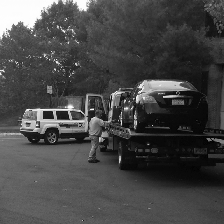

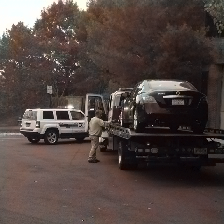

-------------------------


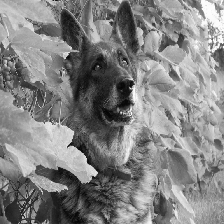

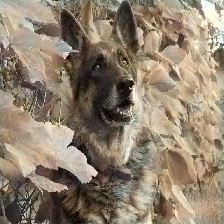

-------------------------


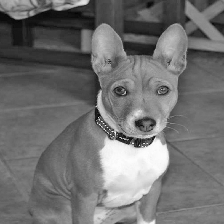

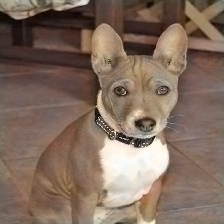

-------------------------


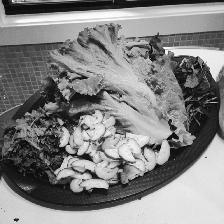

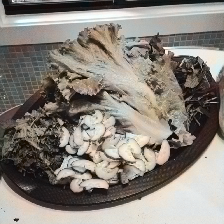

-------------------------


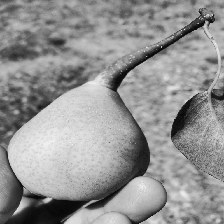

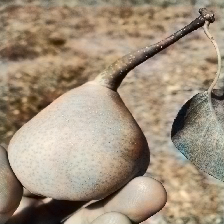

-------------------------


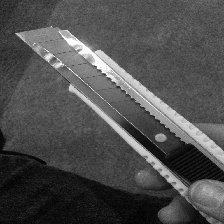

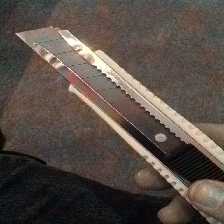

-------------------------


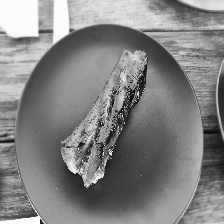

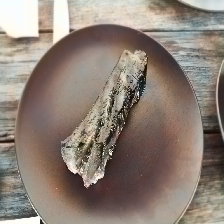

-------------------------


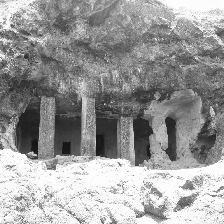

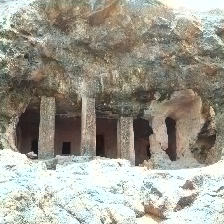

-------------------------


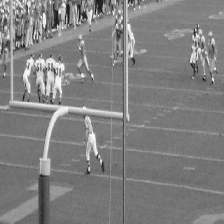

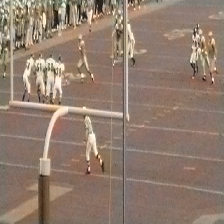

-------------------------


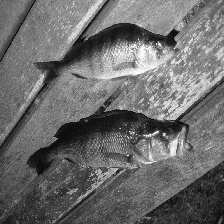

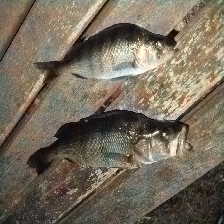

-------------------------


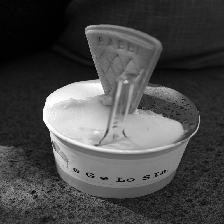

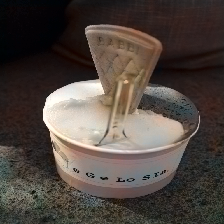

-------------------------


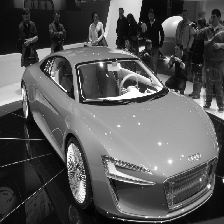

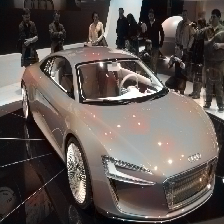

-------------------------


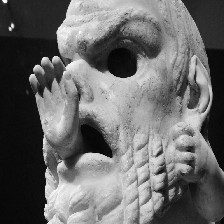

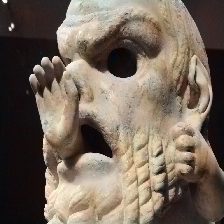

-------------------------


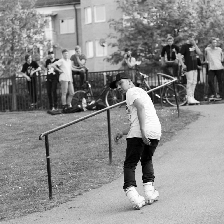

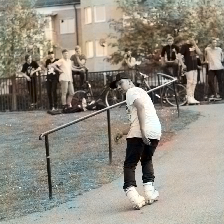

-------------------------


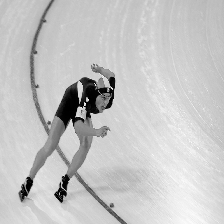

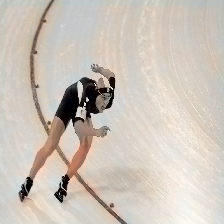

-------------------------


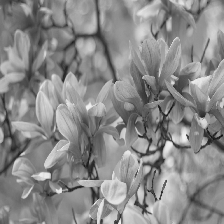

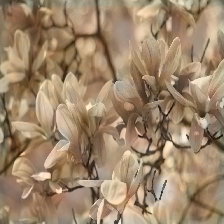

-------------------------


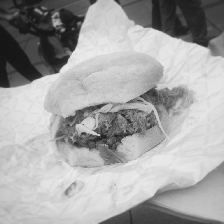

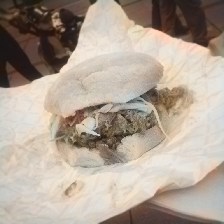

-------------------------


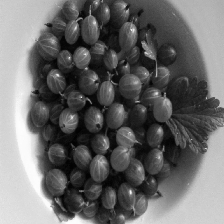

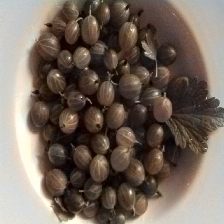

-------------------------


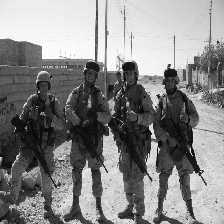

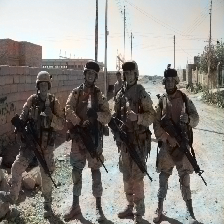

-------------------------


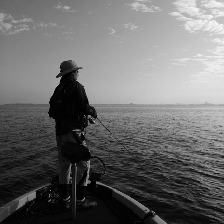

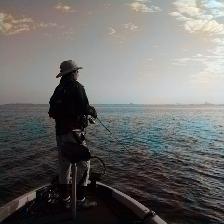

-------------------------


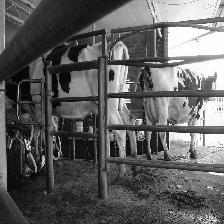

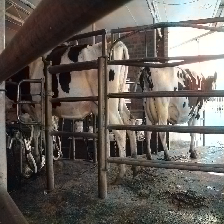

-------------------------


In [15]:
from IPython.display import display_png
from PIL import Image, ImageOps


for i in range(test_preds_rgb.shape[0]): # サンプル数でループ
    gray_image = ImageOps.grayscale(array_to_img(test_preds_rgb[i])) # 予測結果を変換したRGB画像をグレースケールに変換
    display_png(gray_image)
    display_png(array_to_img(test_preds_rgb[i]))
    print('-'*25)
    if i == 20:
        break